### Importing Libraries

In [25]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

### Pre Processing Step

In [26]:
# Load the CSV
file_path = "data/NewsData.io_TSLA.csv"  # Adjust path if needed
df = pd.read_csv(file_path)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13307 entries, 0 to 13306
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   article_id       13307 non-null  object 
 1   title            13307 non-null  object 
 2   link             13307 non-null  object 
 3   keywords         9337 non-null   object 
 4   creator          11907 non-null  object 
 5   video_url        0 non-null      float64
 6   description      12944 non-null  object 
 7   content          11644 non-null  object 
 8   pubDate          13307 non-null  object 
 9   pubDateTZ        13307 non-null  object 
 10  image_url        11625 non-null  object 
 11  source_id        13307 non-null  object 
 12  source_priority  13307 non-null  object 
 13  source_name      13267 non-null  object 
 14  source_url       13267 non-null  object 
 15  source_icon      13222 non-null  object 
 16  language         13307 non-null  object 
 17  country     

In [28]:
df["ai_tag"].value_counts()

ai_tag
"financial markets"                       5183
"automotive"                              3052
"corporate news"                          1152
"awards and recognitions"                  407
"corporate news,financial markets"         358
                                          ... 
"movies,technology"                          1
"e-commerce,cryptocurrencies"                1
"space,research"                             1
"aviation"                                   1
"eco-friendly,renewable energy,energy"       1
Name: count, Length: 177, dtype: int64

In [29]:
# Initialize lemmatizer and stemmer
# lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [30]:
# Checking distinct languages and counting values
df['language'].value_counts()

language
"english"       10523
"spanish"        2748
"german"           14
"french"           13
"romanian"          7
"portuguese"        1
"italian"           1
Name: count, dtype: int64

In [31]:
# Drop rows with missing sentiment or content
df_en = df.dropna(subset=["sentiment", "content"])

# Storing only english content in new df
df_en = df_en[df_en['language'] == '"english"']

# Quick look
df_en[["pubDate", "title", "sentiment"]].head()

,pubDate,title,sentiment
0,"""2025-01-15 22:16:52""","""My Prediction for 2025 – and a Profit-Generat...","""positive"""
1,"""2025-01-15 22:00:00""","""Boeing needs 'tough love,' says Trump's trans...","""positive"""
6,"""2025-01-15 21:13:08""","""NASDAQ snaps five-day losing streak with its ...","""positive"""
7,"""2025-01-15 20:55:20""","""What's Going On With Tesla Shares Wednesday?""","""neutral"""
8,"""2025-01-15 20:42:47""","""Electric Vehicle Sales Leaders — Best Selling...","""neutral"""


In [32]:
# Text preprocessing function
def basic_preprocess(text):
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove punctuation, emojis, special characters (keep letters, numbers, space)
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    
    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()
    
    # Tokenize
    tokens = text.split()
    
    # Remove stopwords and non-alpha tokens
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS and word.isalpha()]
 
    # Apply lemmatization
    # tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Apply stemming
    tokens = [stemmer.stem(word) for word in tokens]

    # Remove single-letter tokens
    tokens = [word for word in tokens if len(word) > 1]
    
    # Return cleaned string
    return " ".join(tokens)

In [33]:
# Show original content
df_en["content"].head(5)

0    "Hello, Reader. Mark Twain once remarked, “The...
1    "President-elect Donald Trump’s nominee to suc...
6    "The major stock indices cheered on the combin...
7    "Tesla, Inc . TSLA stock is trading higher on ...
8    "A closer look at the best-selling PEV automot...
Name: content, dtype: object

In [34]:
# Apply to content
df_en["clean_content"] = df_en["content"].apply(basic_preprocess)
df_en["clean_title"] = df_en["title"].apply(basic_preprocess)
df_en["clean_description"] = df_en["description"].apply(basic_preprocess)

### Plot Most Common Function

In [35]:
def plot_most_common_features(text_col, target_col, n_features=50):
    from matplotlib import interactive

    df = pd.DataFrame({"text": text_col, "CLASS": target_col})
    grouped = df.groupby(["CLASS"]).apply(lambda x: x["text"].sum())
    grouped_df = pd.DataFrame({"CLASS": grouped.index, "text": grouped.values})

    from nltk.tokenize import WhitespaceTokenizer
    tokenizer = WhitespaceTokenizer()

    for ii, text in enumerate(grouped_df.text):
        pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))
        plt.title(grouped_df.CLASS[ii], fontsize=20)
        plt.xticks(fontsize=15)
        plt.legend([])
        interactive(True)
        plt.show()

### Plot most common - Clean Content

/var/folders/3q/csp0v0h521lg_q0zjdwnp_nm0000gn/T/ipykernel_53092/3495920787.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby(["CLASS"]).apply(lambda x: x["text"].sum())
/var/folders/3q/csp0v0h521lg_q0zjdwnp_nm0000gn/T/ipykernel_53092/3495920787.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


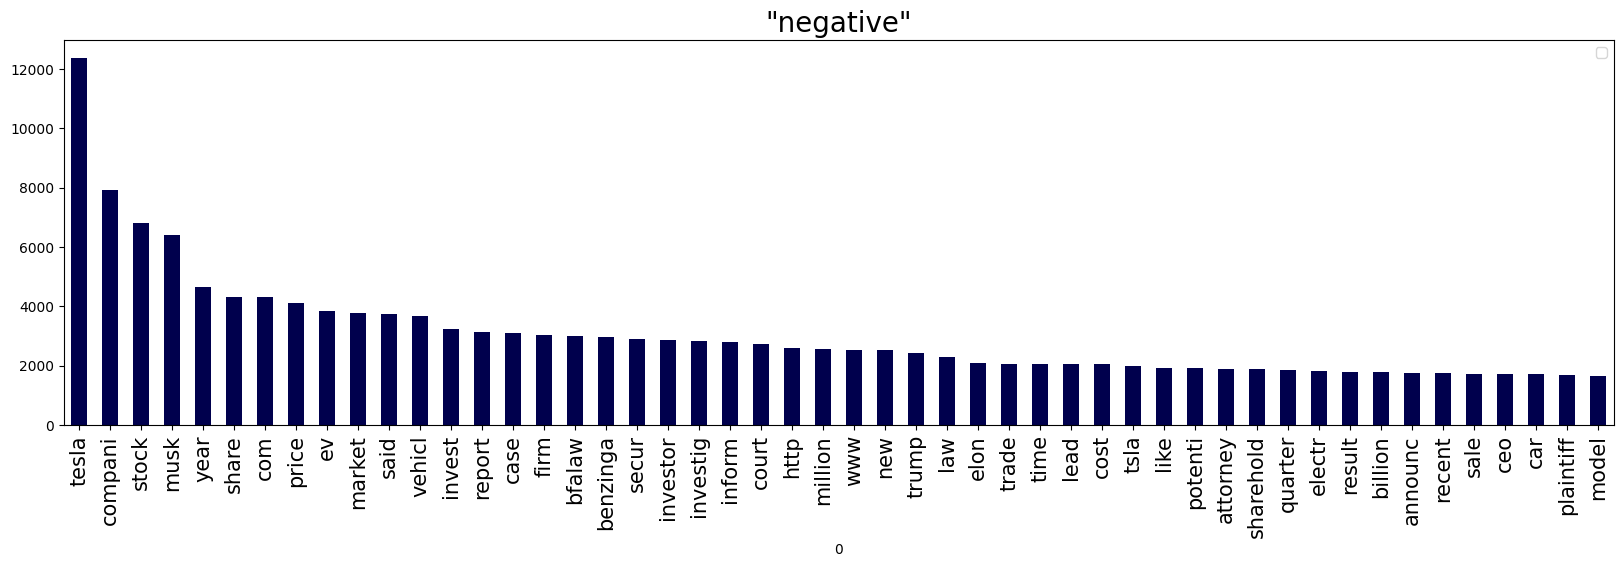

/var/folders/3q/csp0v0h521lg_q0zjdwnp_nm0000gn/T/ipykernel_53092/3495920787.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


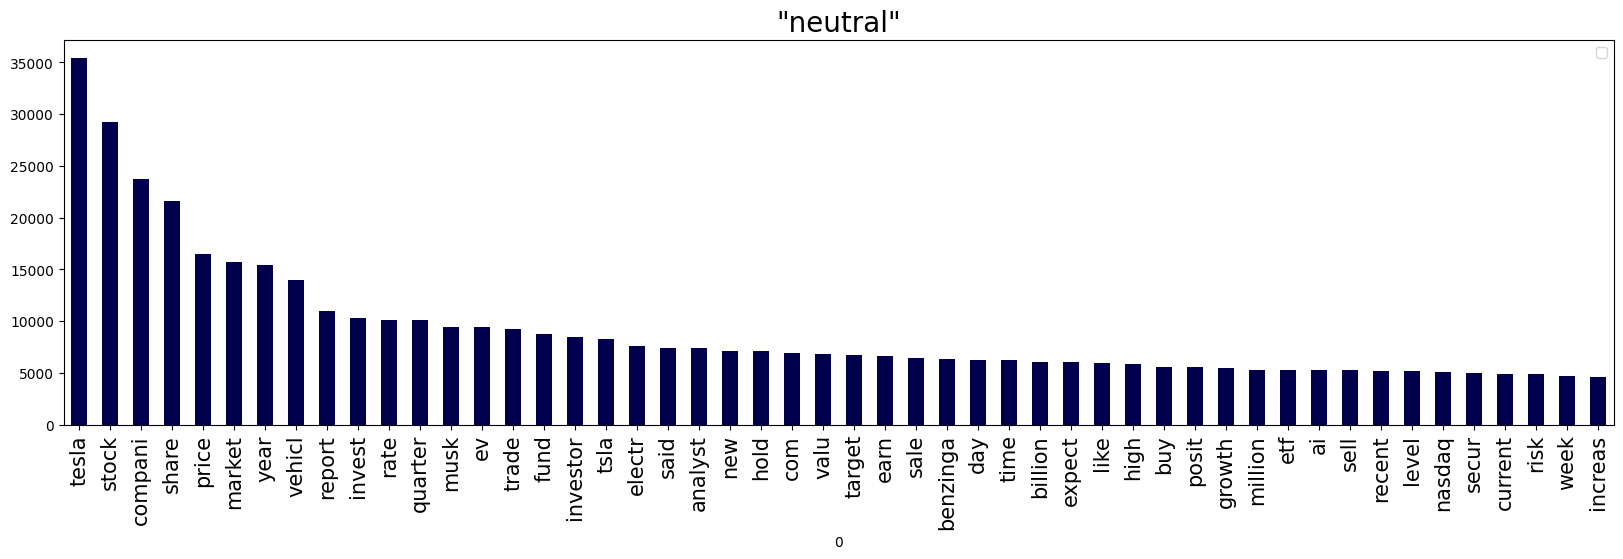

/var/folders/3q/csp0v0h521lg_q0zjdwnp_nm0000gn/T/ipykernel_53092/3495920787.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


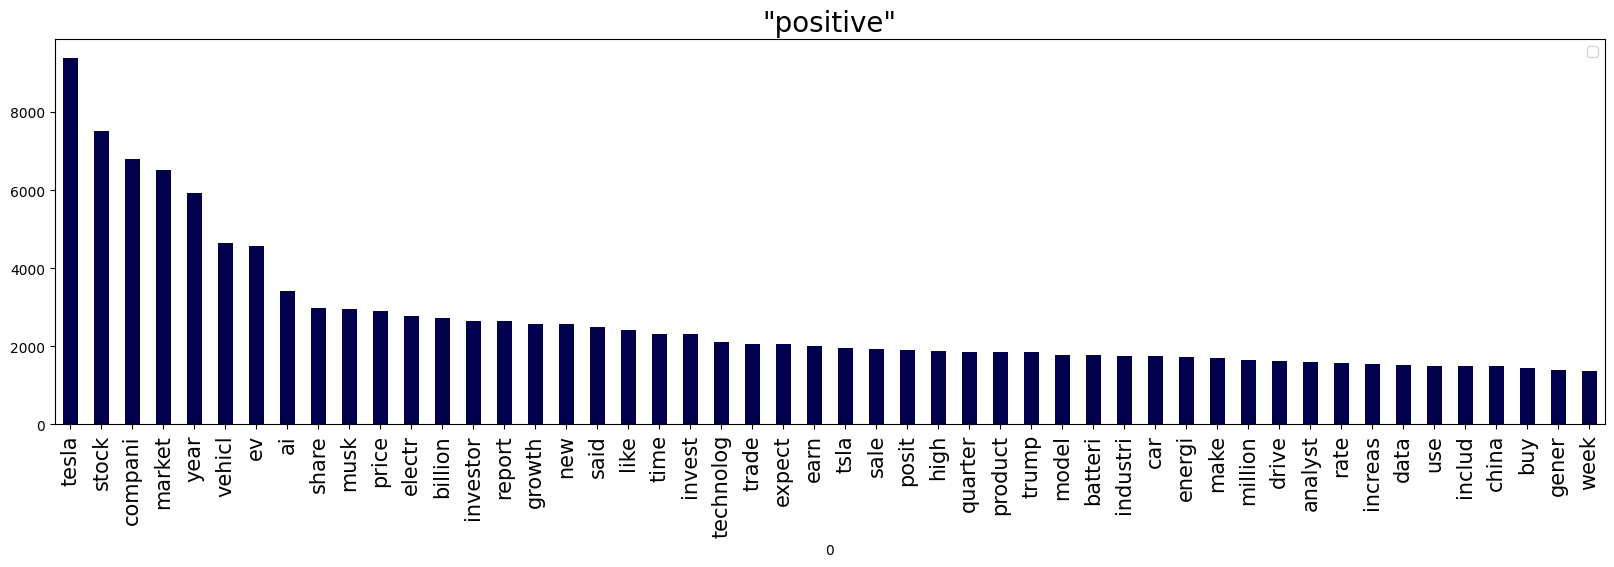

In [36]:
plot_most_common_features(df_en.clean_content, df_en.sentiment)

###  Plot most common - Clean Title

/var/folders/3q/csp0v0h521lg_q0zjdwnp_nm0000gn/T/ipykernel_53092/3495920787.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby(["CLASS"]).apply(lambda x: x["text"].sum())
/var/folders/3q/csp0v0h521lg_q0zjdwnp_nm0000gn/T/ipykernel_53092/3495920787.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


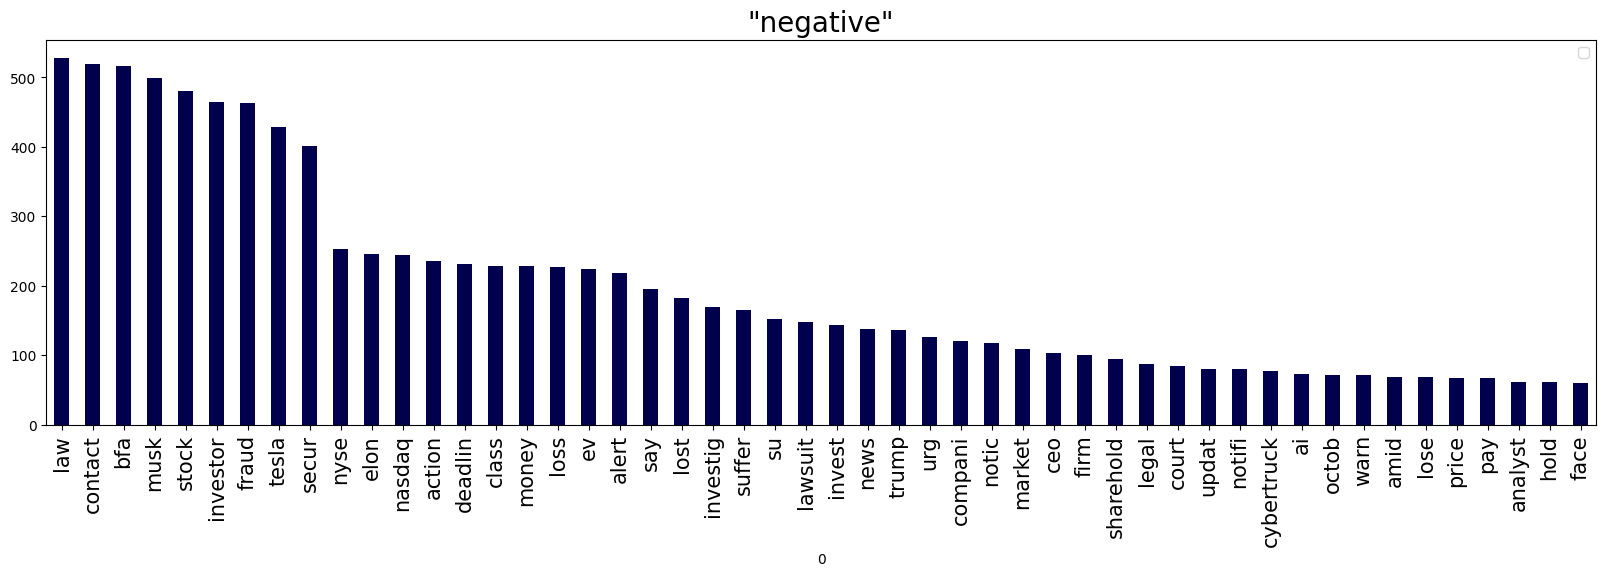

/var/folders/3q/csp0v0h521lg_q0zjdwnp_nm0000gn/T/ipykernel_53092/3495920787.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


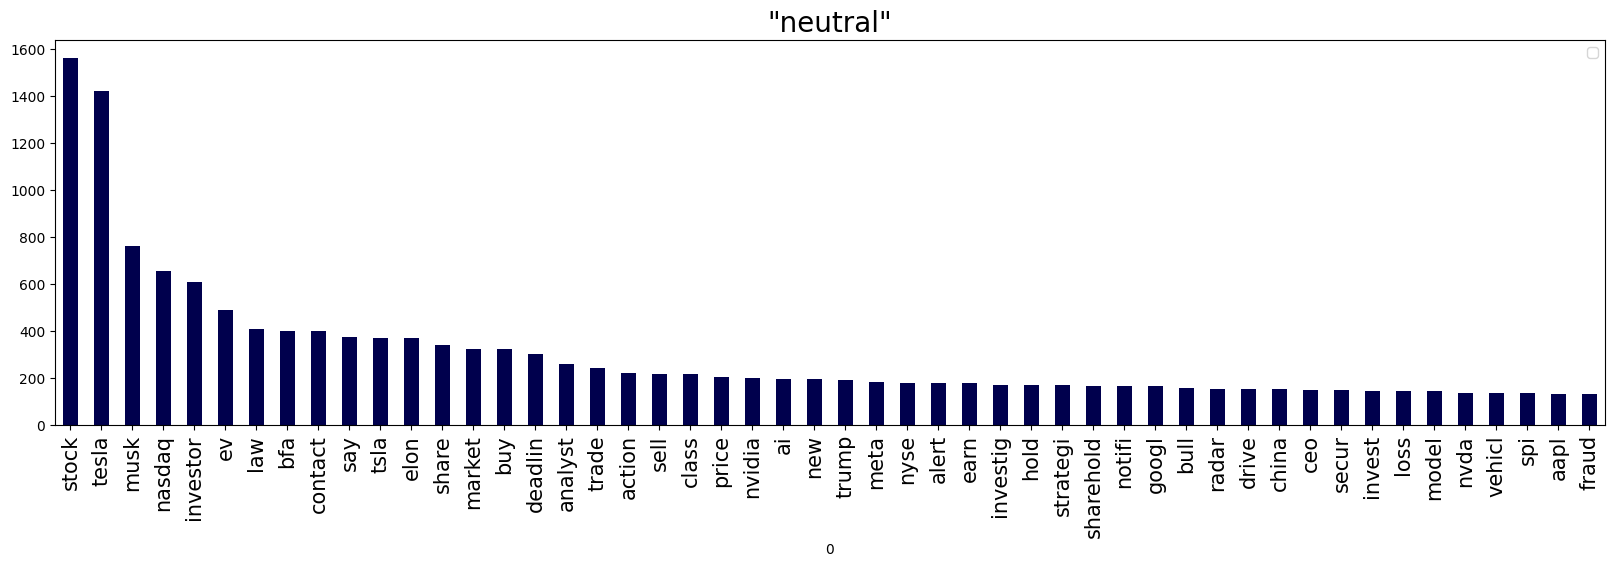

/var/folders/3q/csp0v0h521lg_q0zjdwnp_nm0000gn/T/ipykernel_53092/3495920787.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


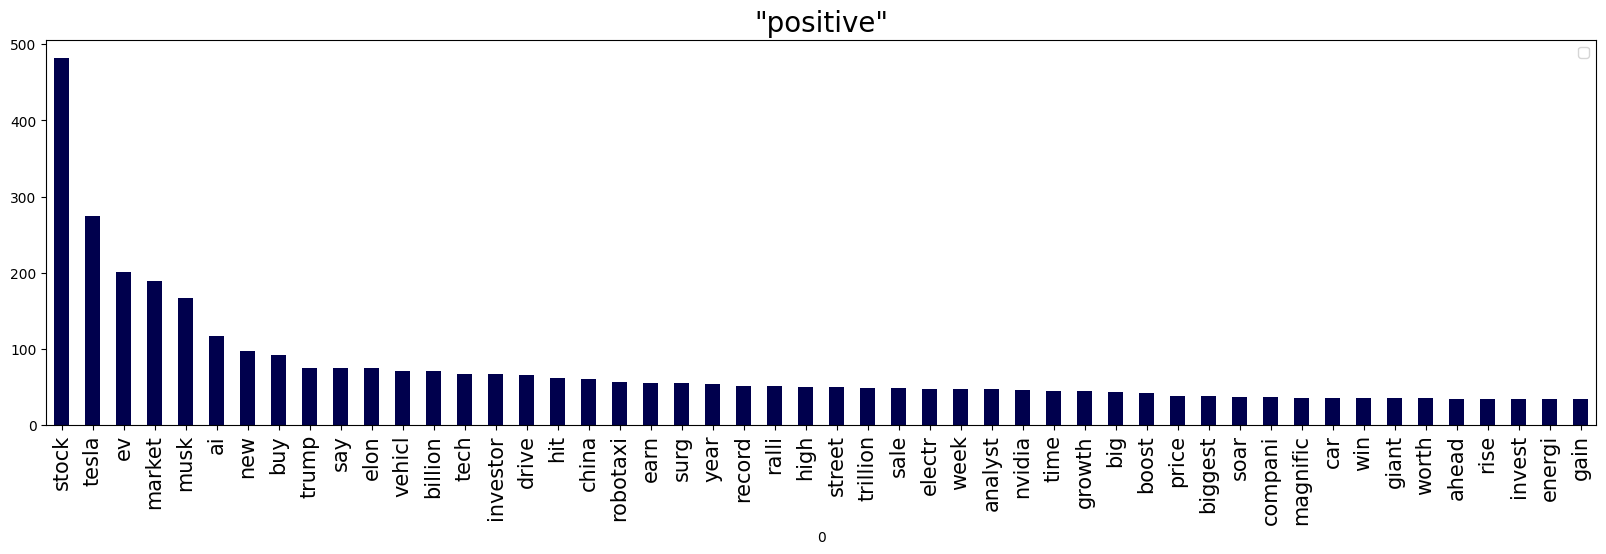

In [37]:
plot_most_common_features(df_en.clean_title, df_en.sentiment)

###  Plot most common - Clean Description

/var/folders/3q/csp0v0h521lg_q0zjdwnp_nm0000gn/T/ipykernel_53092/3495920787.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby(["CLASS"]).apply(lambda x: x["text"].sum())
/var/folders/3q/csp0v0h521lg_q0zjdwnp_nm0000gn/T/ipykernel_53092/3495920787.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


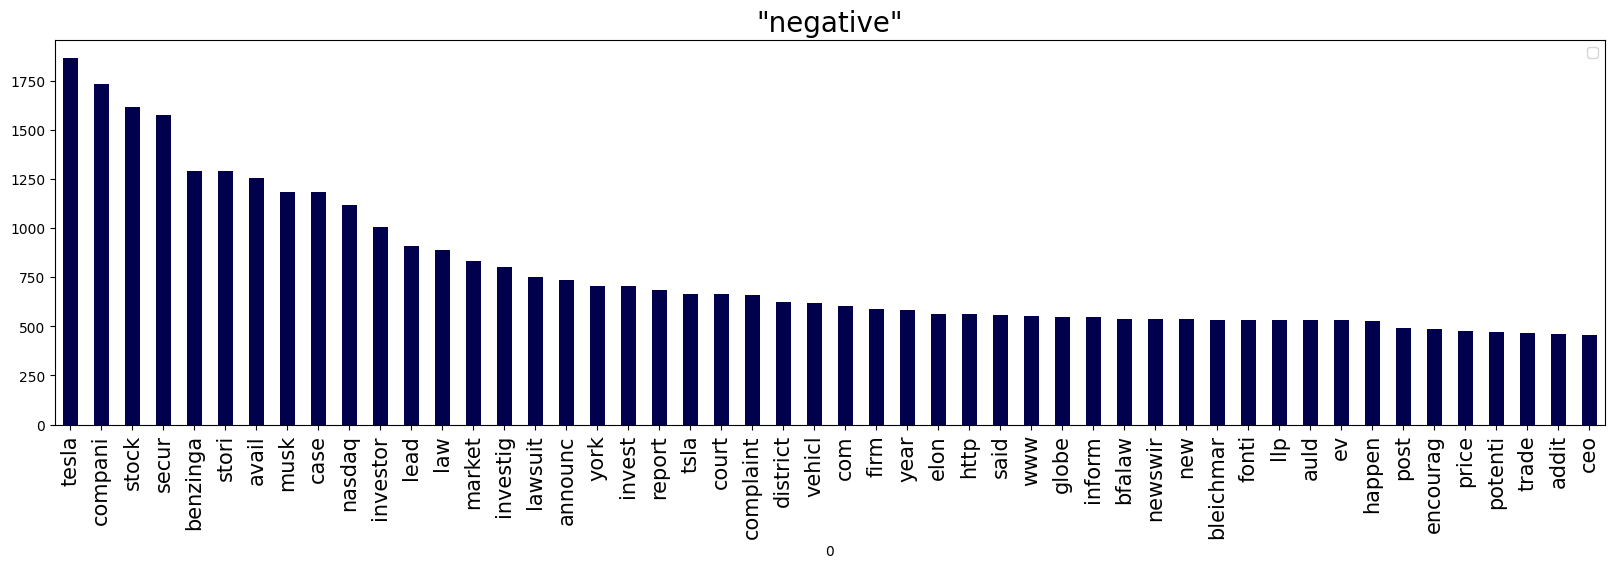

/var/folders/3q/csp0v0h521lg_q0zjdwnp_nm0000gn/T/ipykernel_53092/3495920787.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


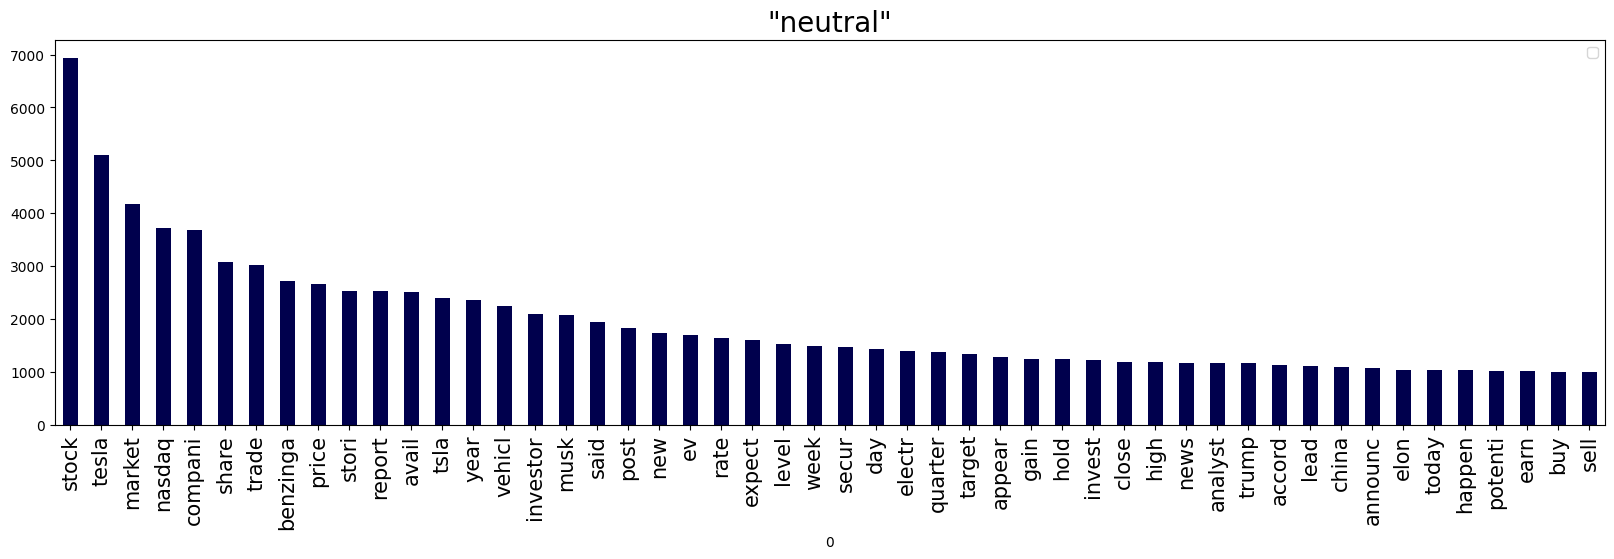

/var/folders/3q/csp0v0h521lg_q0zjdwnp_nm0000gn/T/ipykernel_53092/3495920787.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


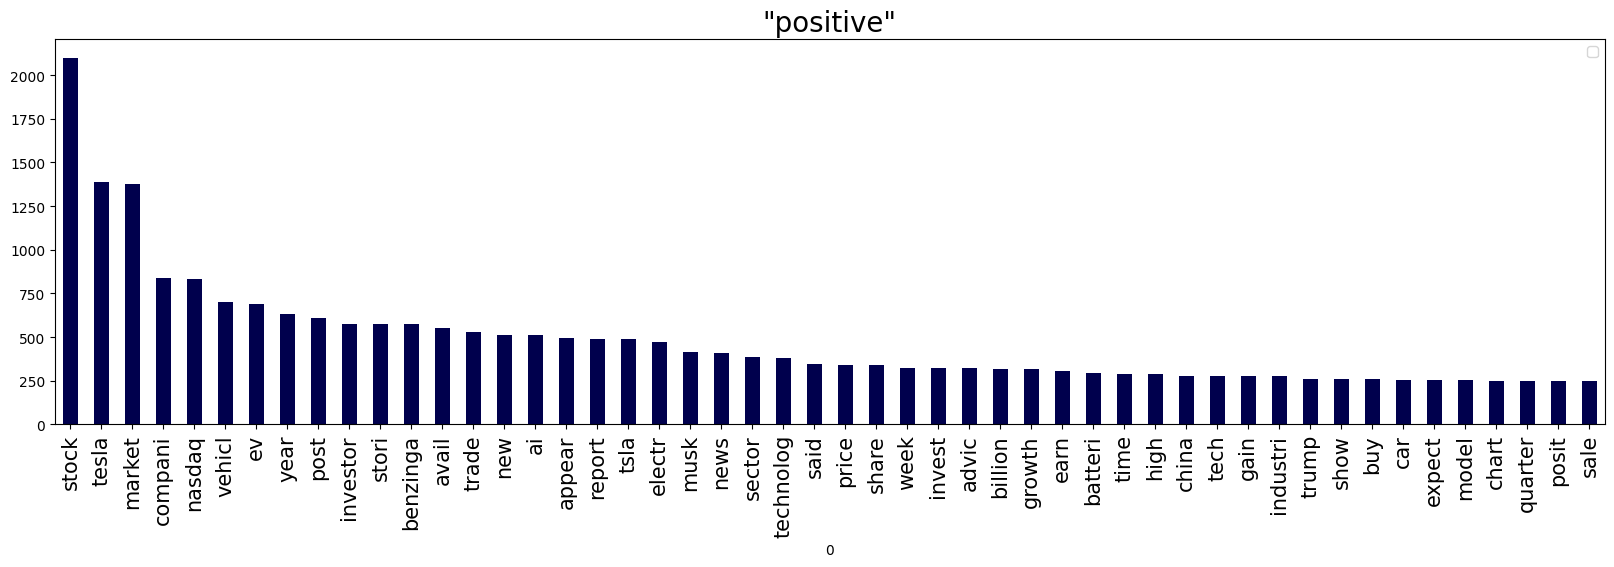

In [38]:
plot_most_common_features(df_en.clean_description, df_en.sentiment)

In [39]:
# We have found that "title" extracts the releavnt keywords (BAG OF WORDS) necessary for sentimental analysis
# Next approach should be applying: BAG OF WORDS Weighting Schemas → TF-IDF Weighting (Use this as the feature for the ML prediction)